### Introduction


**Probelm Statement:** Make a classifier which takes in a job description and gives the department name for it.
*   Use a neural network model
*   Make use of a pre-trained Word Embeddings (example: Word2Vec, GloVe, etc.)
*   Calculate the accuracy on a test set (data not used to train the model)

**Problem Solving Approach:** 
_Provide a brief description of steps you followed for solving this problem_
1. Initially, I read each json file from the docs folder and extracting 'jd_information' value and filling it to the description column with corresponding document id. After getting both the data in the required format. I merge both the dataset using the common field 'Document ID'. Then I look into the dataset and I found that for some records the description is empty so for that I remove those rows because without having description how can we predict department.
2. After getting the final data I perform cleaning and pre-processing on description column. I removes all the html tags, punctuation, stopwords etc present in the job description.
3. Then I perform basic analysis on the data like plotting the department distribution and I found that there are 27 total departments and it also seems that dataset is highly imbalanced. Out of 27 department only 3 department are present more than 100 times and rest are in very less no of times. Some department are present only 1 times. So with these data distribution our model is not going to be predicted each and every department correctly due to the absence of data. I also done some analysis on department wise like average word count in each department, top 15 words for each department etc.
4. After doing basic analysis I perform modelling. I create my own custome word2vec embedding using gensim library and create a small neural network. The testing accuracy that I got is around 46%.

### Part I: Text Preprocessing

_Include all text preprocesing steps like processing of json,csv files & data cleaning in this part._

Import neccessary packages in below cell

In [1]:
# loading the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import json
import os

from gensim.models import Word2Vec
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.initializers import Constant
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

Using TensorFlow backend.


In [2]:
# reading the department data and printing some few records
department=pd.read_csv('data/document_departments.csv')
department.head()

Document ID             Department
0      8196431       Customer service
1      8278123      Digital Marketing
2      8331625                  Sales
3      8331003  Back office ticketing
4      8277939      Digital Marketing

In [3]:
# no of rows and columns in the department data
department.shape

(1162, 2)

In [4]:
# basic information about the data like no of rows, type, null rows etc
department.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162 entries, 0 to 1161
Data columns (total 2 columns):
Document ID    1162 non-null int64
Department     1162 non-null object
dtypes: int64(1), object(1)
memory usage: 18.2+ KB


In [5]:
# creating a dataframe to store document ID and job description
desc = pd.DataFrame(columns=['Document ID','description'])

In [6]:
# reading each json and extracting 'jd_information' value and storing it in Description field
for filename in os.listdir('data/docs'):
    with open('data/docs/'+filename) as f:
        # Read each line of the file
        file_data=json.load(f)
        description=file_data['jd_information']['description']
        desc=desc.append(pd.Series([filename.split('.')[0], description], index=desc.columns), ignore_index=True)

In [7]:
# printing few records of description data with document ID
desc.head()

Document ID                                        description
0     5922081  Urgent positions for Travel Executive at Saane...
1     6523883  Dear Candidate,Greetings From Continental Immi...
2     6600981  We Have urgent poitions for Ticketing Executiv...
3     6686185  We Have Urgent positions for Travel booking cu...
4     6726409  Experience in Travel Industry.We have urgent o...

In [8]:
# no of rows and columns in the description data
desc.shape

(1162, 2)

In [9]:
# basic information about the data like no of rows, type, null rows etc
desc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162 entries, 0 to 1161
Data columns (total 2 columns):
Document ID    1162 non-null object
description    1162 non-null object
dtypes: object(2)
memory usage: 18.2+ KB


In [10]:
# changing the datatype of both the table 'document ID' to be of int type so as to join both the tables 
desc['Document ID']=desc['Document ID'].astype(int)
department['Document ID']=department['Document ID'].astype(int)

In [11]:
# merging the department and description data on common field 'Document ID' and printing few records
data = pd.merge(department, desc, on='Document ID')
data.head()

Document ID             Department  \
0      8196431       Customer service   
1      8278123      Digital Marketing   
2      8331625                  Sales   
3      8331003  Back office ticketing   
4      8277939      Digital Marketing   

                                         description  
0  Designation- TeleMarketing ExecutiveKeyskills-...  
1  We need committed &amp; result-oriented people...  
2  Greetings from Akkam Immigrations!!!Immediate ...  
3  Dear Candidates,Greetings From Continental Imm...  
4  We need committed &amp; result-oriented people...

In [12]:
# no of rows and columns present in final dataframe
data.shape

(1162, 3)

In [13]:
# basic information about the data like no of rows, type, null rows etc
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1162 entries, 0 to 1161
Data columns (total 3 columns):
Document ID    1162 non-null int32
Department     1162 non-null object
description    1162 non-null object
dtypes: int32(1), object(2)
memory usage: 31.8+ KB


In [14]:
# printing records where description is absent
data[data.description=='']

Document ID                       Department description
89        8194299                            Sales            
107       8220523                        Ticketing            
176       8283481                        Ticketing            
225       8104553                            Sales            
294       8066330                            Sales            
433       7831591                            Sales            
447       7886593                          Finance            
450       7881493                       Operations            
487       8264142                        Ticketing            
489       8274814                        Ticketing            
496       7962627                        Ticketing            
503       8274570                        Ticketing            
516       8262146                      Maintenance            
517       8131590                   Administration            
519       8171912                        Ticketing            
523       8170788                            Sales            
525       8131576                          Finance            
527       8118306                        Ticketing            
528       8231256          Marine Service Steward             
530       8203232                            Sales            
532       8210186                              QA             
533       8260186                        Ticketing            
535       8140750                        Ticketing            
537       8226067                        Ticketing            
539       8170792                            Sales            
541       8228604                 Customer service            
543       8203252                   Administration            
545       8170790                            Sales            
551       8255032                       Operations            
555       8131558                        Ticketing            
...           ...                              ...         ...
1116      8381302                   Administration            
1118      8370928                Digital Marketing            
1121      8370870                          Finance            
1122      8366386                      Maintenance            
1123      8370906                        Marketing            
1125      8389341                        Ticketing            
1127      8370874                Digital Marketing            
1128      8370890                Digital Marketing            
1129      8366374                   Administration            
1130      8366384                          Finance            
1131      8370892                        Marketing            
1132      8370876                Digital Marketing            
1134      8370900  Engineering Design Construction            
1136      8366370                   Administration            
1138      8370902            Management Consulting            
1139      8370886                        Marketing            
1141      8370866                          Finance            
1142      8370880                        Marketing            
1143      8366376                   Administration            
1144      8370912                        Marketing            
1145      8370858                        Analytics            
1146      8370868                               IT            
1147      8370860                       Operations            
1148      8370864                       Operations            
1149      8370882                Digital Marketing            
1151      8370910                       Operations            
1153      8370872            Management Consulting            
1154      8370908                        Marketing            
1155      8370898                        Marketing            
1157      8366382                   Administration            

[417 rows x 3 columns]

In [15]:
# removing all the rows where description is empty and checking the final dataset size
data['description'].replace('', np.nan, inplace=True)
data.dropna(subset=['description'], inplace=True)
data.shape

(745, 3)

In [16]:
# printing a sample of description without pre-processing
def print_plot(index):
    example = data[data.index == index][['description', 'Department']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Department:', example[1])
print_plot(0)

Designation- TeleMarketing ExecutiveKeyskills- communication sales, outbound process, calling, domestic BPO, call center. Customer handling, voice processEducation- HSC Passed, Fresher Also WelcomeLocation- PUNE, NAVI MUMBAI (VASHI), MUMBAI (GOREGAON) , AHMADABADSalary- depend on candidate.CONTAC NO.- 9004493548thanx &amp; RegardsHR Sonali.
Department: Customer service


In [17]:
# text processing for removing html, punctuation, stopwords from the text
stop = set(stopwords.words('english')) #set of stopwords

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [18]:
# This snippet removes all the html, punctuation, stopwords etc from the description 
def clean_text(text):
    filtered_sentence=[]

    sent=cleanhtml(text) # remove HTMl tags

    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():

            if((cleaned_words.isalpha()) ):

                if(cleaned_words.lower() not in stop):

                    s=(cleaned_words.lower()).encode('utf8')
                    filtered_sentence.append(s)
    str1 = b" ".join(filtered_sentence) 
    return str1

In [19]:
# calling the clean_text function on description column row by row and getting the cleaned text and storing the same in description column
data['description'] = data['description'].apply(clean_text)
data['description'] = data['description'].str.decode("utf-8")

In [20]:
# printing few samples of data after pre-processing
data.head()

Document ID             Department  \
0      8196431       Customer service   
1      8278123      Digital Marketing   
2      8331625                  Sales   
3      8331003  Back office ticketing   
4      8277939      Digital Marketing   

                                         description  
0  telemarketing communication sales outbound pro...  
1  need committed people join hands us contribute...  
2  greetings akkam immigrationsimmediate requirem...  
3  dear candidates greetings continental immigrat...  
4  need committed people join hands us contribute...

In [21]:
# printing a sample of description after pre-processing
print_plot(0)

telemarketing communication sales outbound process calling domestic bpo call center customer handling voice hsc passed fresher also pune navi mumbai vashi mumbai goregaon depend candidate contac regardshr sonali
Department: Customer service


### Part II: Exploratoty Data Analysis

_Include EDA steps like finding distribution of Departments in this part, you may also use plots for EDA._

In [22]:
data.Department.value_counts()

Ticketing                          230
Sales                              148
Digital Marketing                  132
Customer service                    49
Marketing                           30
Finance                             26
Operations                          25
Back office ticketing               16
Administration                      15
IT                                  13
Technology                          10
Presales                            10
Maintenance                          8
Public Relations                     5
Recruitment                          5
Engineering Design Construction      4
Marine Engineering                   3
Logistics                            3
Marine Deck                          2
Content                              2
Data entry                           2
Analytics                            2
Procurement                          1
Learning and Development             1
Flight Operations                    1
Marine Service Steward   

Text(0.5, 1.0, 'Distribution of Department through pie-chart')

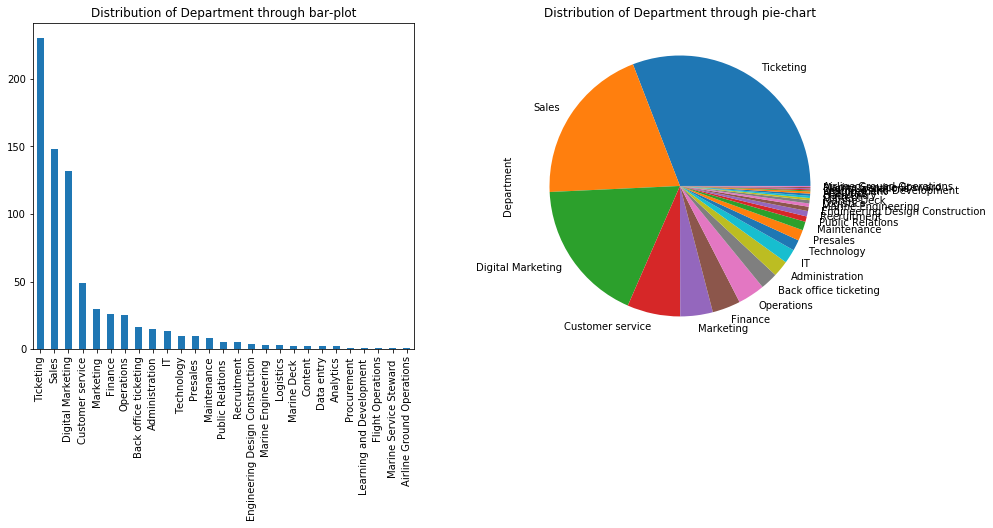

In [23]:
# Distribution of Departments through bar plot and pie chart
plt.figure(figsize=(15,6))
plt.subplot(121)
data.Department.value_counts().plot(kind='bar')
plt.title('Distribution of Department through bar-plot')

plt.subplot(122)
data.Department.value_counts().plot(kind='pie')
plt.title('Distribution of Department through pie-chart')

In [24]:
# no of unique department
data.Department.nunique()

27

In [25]:
def word_count(text):
    return len(str(text).split(' '))

In [29]:
# printing Avg word count by category

data['word_count'] = data['description'].apply(word_count)
avg_wc = data.groupby('Department').mean().reset_index()
wc=avg_wc[['Department','word_count']]
wc

Department  word_count
0                    Administration   52.333333
1         Airline Ground Operations  177.000000
2                         Analytics  215.500000
3             Back office ticketing   56.625000
4                           Content   61.000000
5                  Customer service   47.755102
6                        Data entry   49.000000
7                 Digital Marketing   51.295455
8   Engineering Design Construction   27.750000
9                           Finance   31.807692
10                Flight Operations   22.000000
11                               IT   24.538462
12        Learning and Development   206.000000
13                        Logistics   37.666667
14                      Maintenance   30.250000
15                     Marine Deck    74.000000
16              Marine Engineering    24.000000
17          Marine Service Steward    28.000000
18                        Marketing   59.966667
19                       Operations   49.440000
20                        Presales    92.500000
21                      Procurement   28.000000
22                Public Relations    32.600000
23                      Recruitment   32.200000
24                            Sales   59.837838
25                       Technology   56.600000
26                        Ticketing   61.926087

<Figure size 1800x720 with 0 Axes>

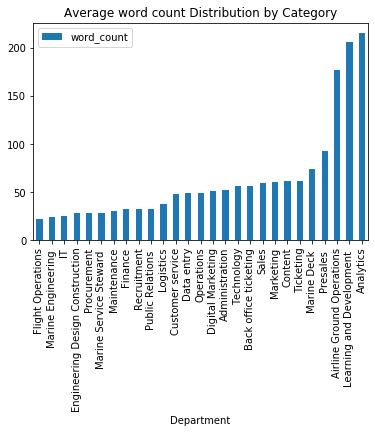

In [41]:
# Average word count distribution of each category
wc.index=wc['Department']
wc.drop('Department',axis=1)
plt.figure(figsize=(25,10))
wc.sort_values(by='word_count').plot.bar()
plt.title('Average word count Distribution by Category')
plt.show()

In [51]:
#Splitting the data into the different department
df_ticketing = data.loc[data['Department'] == 'Ticketing'] 
df_sales = data.loc[data['Department'] =='Sales']
df_digital = data.loc[data['Department'] == 'Digital Marketing'] 
df_customer = data.loc[data['Department'] == 'Customer service'] 


In [52]:
text_ticketing = df_ticketing.description.str.split().tolist()
text_sales = df_sales.description.str.split().tolist()
text_digital = df_digital.description.str.split().tolist()
text_customer = df_customer.description.str.split().tolist()

In [53]:

def word_freq(clean_text_list, top_n):
    """
    Word Frequency
    """
    flat = [item for sublist in clean_text_list for item in sublist]
    with_counts = Counter(flat)
    top = with_counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T

In [54]:
top_n=15
ticketing = word_freq(text_ticketing, top_n=top_n)
sales = word_freq(text_sales, top_n=top_n)
digital = word_freq(text_digital, top_n=top_n)
customer = word_freq(text_customer, top_n=top_n)

In [55]:
#Top 15 words by top 4 Department
df_wf = pd.concat([ticketing, sales, digital, customer], axis=1)
cols = ['ticketing', 'count', 'sales', 'count', 'digital', 'count', 'customer', 'count']
df_wf.columns = cols
df_wf

ticketing count          sales count     digital count       customer  \
0          travel   411          sales   237        work   274         travel   
1       knowledge   176        clients   145        time   232       customer   
2           sales   127         travel   117     tourism   218      candidate   
3         clients   120            new    83      travel   212           call   
4         company   117         client    77        earn   211     experience   
5      experience   109      corporate    71      income   173           good   
6            tour    99       business    69   promotion   160      knowledge   
7   international    97        company    68     company   150  international   
8       candidate    97            job    65       india   149         skills   
9            good    94     experience    60   vacations   148  communication   
10            job    91  communication    59      online   135        process   
11         client    82       packages    54    required   117            job   
12         skills    82      candidate    52         per   113        service   
13       customer    79       customer    52      target   109       domestic   
14     candidates    79         skills    51  boundation   109         hiring   

   count  
0     57  
1     35  
2     31  
3     30  
4     30  
5     29  
6     29  
7     29  
8     26  
9     25  
10    25  
11    24  
12    23  
13    20  
14    20

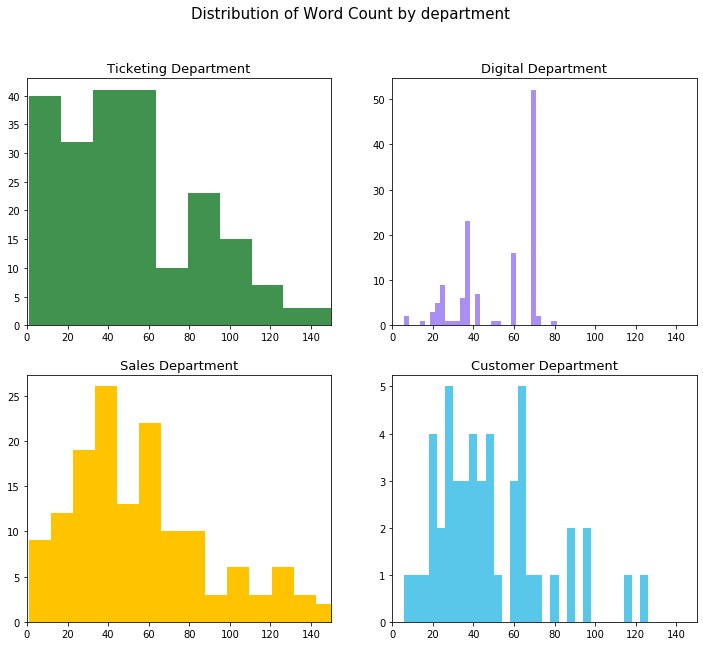

In [56]:
#Plot the distribution of word count department wise taking top 4 department only

fig, ax = plt.subplots(2, 2, figsize = (12,10))
fig.suptitle('Distribution of Word Count by department', fontsize=15)

bins = 30

ax[0, 0].hist(df_ticketing['word_count'], bins = bins, color = '#41924F')
ax[0, 0].set_title('Ticketing Department', fontsize = 13)
ax[0, 0].set_xlim(0, 150)

ax[1, 0].hist(df_sales['word_count'], bins = bins, color = '#FFC300')
ax[1, 0].set_title('Sales Department', fontsize = 13)
ax[1, 0].set_xlim(0, 150)

ax[0, 1].hist(df_digital['word_count'], bins = bins, color = '#a98ff3')
ax[0, 1].set_title('Digital Department', fontsize = 13)
ax[0, 1].set_xlim(0, 150)

ax[1, 1].hist(df_customer['word_count'], bins = bins, color = '#59C7EA')
ax[1, 1].set_title('Customer Department', fontsize = 13)
ax[1, 1].set_xlim(0, 150)

plt.show()

### Part III: Modelling & Evaluation

_Include all model prepration & evaluation steps in this part._

### Modelling using custom Word2Vec Embedding

In [95]:
# defining parameters used to build a model
EMBEDDING_DIM=100
MAX_SEQUENCE_LENGTH = 150

In [119]:
# creating a list of sentences by pre-processing it so as to create a custom Word2Vec model
list_of_sent=[]
lines=data.description.values.tolist()
for line in lines:
    tokens=word_tokenize(line)
    tokens=[w.lower() for w in tokens]
    table= str.maketrans('','',string.punctuation)
    stripped=[w.translate(table) for w in tokens]
    words=[word for word in stripped if word.isalpha()]
    stop_words=set(stopwords.words('english'))
    words=[w for w in words if not w in stop_words]
    list_of_sent.append(words)

In [120]:
# no of such sentences
print(len(list_of_sent))

745


In [122]:
# creating our own word2vec model
w2v_model=gensim.models.Word2Vec(list_of_sent,size=EMBEDDING_DIM, min_count=1, window=5, workers=4)
w2v = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v))

number of words that occured minimum 5 times  4824


In [123]:
# saving the word2vec model in txt file
filename='embeddings_1.txt'
w2v_model.wv.save_word2vec_format(filename, binary=False)

In [124]:
# load the word embedding as a directory of words to vectors
embedding_index={}
f=open(os.path.join('','embeddings_1.txt'),encoding="utf-8")
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:])
    embedding_index[word]=coefs
f.close()    

In [125]:
# converting the word embedding into tokenized vector
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['description'].values)
X = tokenizer.texts_to_sequences(data['description'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Found 4824 unique tokens.
Shape of data tensor: (745, 150)


In [126]:
# mapping embeddings from the loaded word2vec model for each word
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i>num_words:
        continue
    embedding_vector=embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector

In [127]:
print(num_words)

4825


In [128]:
# defining our model architecture
model = Sequential()

model.add(Embedding(num_words, EMBEDDING_DIM, embeddings_initializer=Constant(embedding_matrix), input_length=MAX_SEQUENCE_LENGTH, trainable=False))

model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(27, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 150, 100)          482500    
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_9 (Dense)              (None, 27)                891       
Total params: 500,415
Trainable params: 17,915
Non-trainable params: 482,500
_________________________________________________________________
None


In [129]:
Y = pd.get_dummies(data.Department).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (745, 27)


In [130]:
# train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(596, 150) (596, 27)
(149, 150) (149, 27)


In [131]:
# training the model 
epochs = 6
batch_size = 16

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

Train on 476 samples, validate on 120 samples
Epoch 1/6
476/476 [==============================] - 32s 68ms/step - loss: 3.0810 - acc: 0.3340 - val_loss: 2.8195 - val_acc: 0.4917
Epoch 2/6
476/476 [==============================] - 10s 22ms/step - loss: 2.7423 - acc: 0.3908 - val_loss: 2.5093 - val_acc: 0.4917
Epoch 3/6
476/476 [==============================] - 11s 23ms/step - loss: 2.4638 - acc: 0.3845 - val_loss: 2.3043 - val_acc: 0.5000
Epoch 4/6
476/476 [==============================] - 12s 26ms/step - loss: 2.2818 - acc: 0.3782 - val_loss: 2.1791 - val_acc: 0.3083
Epoch 5/6
476/476 [==============================] - 11s 23ms/step - loss: 2.1727 - acc: 0.3004 - val_loss: 2.0902 - val_acc: 0.3083
Epoch 6/6
476/476 [==============================] - 12s 25ms/step - loss: 2.0981 - acc: 0.3803 - val_loss: 2.0236 - val_acc: 0.5167


In [132]:
# function to plot accuracy and loss curve
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Training Accuracy: 0.4581
Testing Accuracy:  0.4631


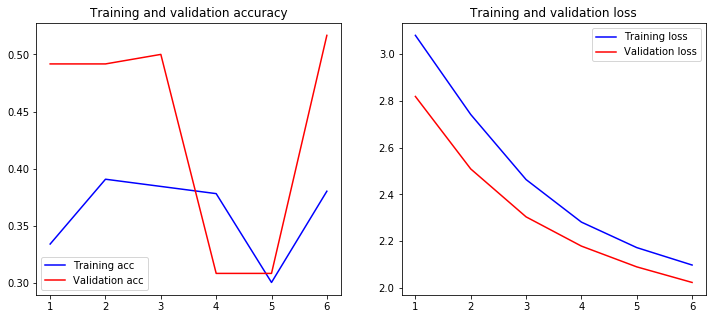

In [133]:
loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

### Modelling without using word2vec embedding

In [117]:
# representing a word with a number
MAX_NB_WORDS = 10000

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['description'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 4824 unique tokens.


In [118]:
# creating a set of sequences of vectors using tokenizer.fit_on_texts
X = tokenizer.texts_to_sequences(data['description'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (745, 150)


In [119]:
# encoding the target variable
Y = pd.get_dummies(data.Department).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (745, 27)


In [120]:
# train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(596, 150) (596, 27)
(149, 150) (149, 27)


In [127]:
# defining model architecture
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(27, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 50)           500000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 150, 50)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_20 (Dense)             (None, 27)                2727      
Total params: 563,127
Trainable params: 563,127
Non-trainable params: 0
_________________________________________________________________
None


In [128]:
# training the model 
epochs = 8
batch_size = 32

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

Train on 476 samples, validate on 120 samples
Epoch 1/8
476/476 [==============================] - ETA: 4:38 - loss: 3.2943 - acc: 0.125 - ETA: 2:18 - loss: 3.2903 - acc: 0.234 - ETA: 1:30 - loss: 3.2874 - acc: 0.260 - ETA: 1:06 - loss: 3.2844 - acc: 0.296 - ETA: 50s - loss: 3.2836 - acc: 0.287 - ETA: 40s - loss: 3.2814 - acc: 0.29 - ETA: 32s - loss: 3.2775 - acc: 0.30 - ETA: 25s - loss: 3.2740 - acc: 0.32 - ETA: 20s - loss: 3.2704 - acc: 0.32 - ETA: 16s - loss: 3.2643 - acc: 0.33 - ETA: 11s - loss: 3.2590 - acc: 0.33 - ETA: 8s - loss: 3.2522 - acc: 0.3464 - ETA: 5s - loss: 3.2442 - acc: 0.358 - ETA: 2s - loss: 3.2322 - acc: 0.359 - 43s 90ms/step - loss: 3.2168 - acc: 0.3613 - val_loss: 2.6810 - val_acc: 0.3083
Epoch 2/8
476/476 [==============================] - ETA: 18s - loss: 2.7485 - acc: 0.31 - ETA: 17s - loss: 2.6005 - acc: 0.29 - ETA: 15s - loss: 2.5437 - acc: 0.31 - ETA: 13s - loss: 2.5695 - acc: 0.30 - ETA: 12s - loss: 2.5427 - acc: 0.28 - ETA: 11s - loss: 2.4627 - acc: 0.27 

Training Accuracy: 0.6057
Testing Accuracy:  0.4899


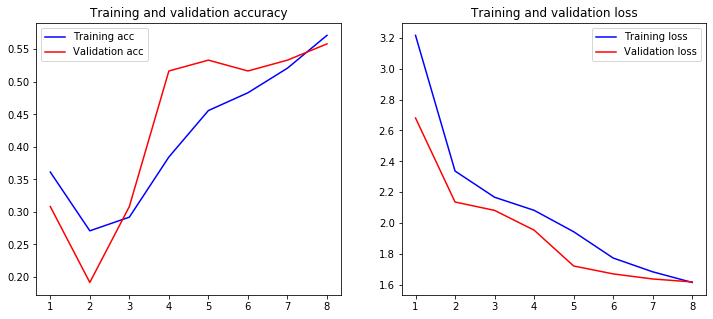

In [129]:
# loss and accuracy curve
loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

**Results Summary:**
_Provide a brief summary of results obtained like model accuracy & other insights based on EDA & your interpretations_

1. Based on basic analysis of the data I have found that there are total 1162 documents in which 417 documents does not have description i.e description is null and 745 documents have description. These 745 documents have 27 unique departments and Ticketing is having most number of documents among all the 27 departments i.e 230 documents and some department have only 1 document like Marine Service Steward.
2. Based on my basic neural network with word2vec embedding I got test accuracy of 46% and without using  word2vec embedding I got test accuracy of 49%.
3. With using Word2vec embedding model the training and testing accuracy is almost similar while without using word2vec embedding model the model is overfitting a bit. The train accuaracy is about 60% and test accuracy is about 49%.
4. We can increase the accuracy by hypertuning the parameters of the model and by having more data for each department so that model can learn specific pattern for each and every department.